# Baseline Models: PCA & Isolation Forest

**Objective**: Establish a performance baseline for anomaly detection using classical machine learning methods.
**Comparison target**: LSTM Autoencoder (Notebook 06).

## Models
1.  **PCA (Principal Component Analysis)**: Detects anomalies based on high reconstruction error (Linear assumption).
2.  **Isolation Forest**: Detects anomalies as data points that are "few and different" (Tree-based).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
import os
import sys

# --- Auto-Detection: Local vs Kaggle ---
# Strategy: If we can import 'src.config', we are in the Project Environment (Local/MinIO).
# If we cannot, we are in a standalone Kernel (Kaggle).

sys.path.append(os.path.abspath(".."))

try:
    from src import config
    IS_LOCAL_ENV = True
    print("✅ Environment Detected: LOCAL (Project Structure Found)")
    
    # Import Constants from Config
    FEATURES = config.TENSOR_FEATURES
    BUCKET_GOLD = getattr(config, "BUCKET_GOLD", "gold")
    
except ImportError:
    IS_LOCAL_ENV = False
    print("🌍 Environment Detected: KAGGLE (Standalone Kernel)")
    
    # Hardcoded Fallbacks for Kaggle
    FEATURES = [
        "dynamic_tensile_strength", "ejection", "tbl_speed", "cyl_main", "tbl_fill"
    ]
    BUCKET_GOLD = "gold"

# --- Data Loading Logic ---
storage_options = None

if IS_LOCAL_ENV:
    # LOCAL: Use MinIO/S3 via pandas storage_options
    # We assume 'src.config' implies S3 connectivity is desired/configured.
    print("☁️  Configuring S3/MinIO Connection...")
    DATA_DIR = f"s3://{BUCKET_GOLD}"
    RESULTS_DIR = "results/baseline"
    
    storage_options = {
        "client_kwargs": {
            "endpoint_url": os.getenv("S3_ENDPOINT", "http://localhost:9000"),
            "aws_access_key_id": os.getenv("AWS_ACCESS_KEY_ID", "minio"),
            "aws_secret_access_key": os.getenv("AWS_SECRET_ACCESS_KEY", "minio123"),
            "region_name": os.getenv("AWS_REGION", "us-east-1")
        }
    }
    
    # Sanity check: Remove endpoint_url if it looks like real AWS
    endpoint = storage_options["client_kwargs"]["endpoint_url"]
    if not endpoint or "amazonaws.com" in endpoint:
        del storage_options["client_kwargs"]["endpoint_url"]
        
else:
    # KAGGLE: Use Local Filesystem Paths
    print("💾 Configuring Local Filesystem Paths...")
    if os.path.exists("/kaggle/input/anomalydetection4pharma-gold-tensor/train.parquet"):
        DATA_DIR = "/kaggle/input/anomalydetection4pharma-gold-tensor"
        RESULTS_DIR = "/kaggle/working/results"
    else:
        print("ERROR")

os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Using Data Dir: {DATA_DIR}")
print(f"Using Results Dir: {RESULTS_DIR}")


🌍 Environment Detected: KAGGLE (Standalone Kernel)
💾 Configuring Local Filesystem Paths...
Using Data Dir: /kaggle/input/anomalydetection4pharma-gold-tensor
Using Results Dir: /kaggle/working/results
asas


## 1. Load Data

In [3]:
# Load Gold Parquet (Supports S3 via storage_options)
try:
    df_train = pd.read_parquet(f"{DATA_DIR}/train.parquet", storage_options=storage_options)[FEATURES]
    df_test = pd.read_parquet(f"{DATA_DIR}/test.parquet", storage_options=storage_options)[FEATURES]
except Exception as e:
    print(f"Error loading data: {e}")
    print("If using S3, check your credentials and endpoint.")
    print("If Local, check your path.")
    raise e

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

# NOTE: Data is already MinMax Scaled [0, 1] from ETL.
df_train.describe()

Train Shape: (813103, 5)
Test Shape: (174237, 5)


,dynamic_tensile_strength,ejection,tbl_speed,cyl_main,tbl_fill
count,813103.000000,813103.000000,813103.000000,813103.000000,813103.000000
mean,0.227775,0.182376,0.548304,0.369215,0.299974
std,0.152779,0.110815,0.071033,0.215097,0.187581
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.110952,0.121864,0.498495,0.161049,0.128065
50%,0.142873,0.173238,0.598796,0.419476,0.306540
75%,0.323235,0.227001,0.598796,0.520599,0.336512
max,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. PCA (Linear Reconstruction)

In [4]:
# Fit PCA
N_COMPONENTS = 3

pca = PCA(n_components=N_COMPONENTS)
pca.fit(df_train)

print(f"Explained Variance per component: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# Save Model
joblib.dump(pca, os.path.join(RESULTS_DIR, 'pca_model.pkl'))

Explained Variance per component: [0.76522247 0.12746803 0.06066029]
Total Explained Variance: 0.9534


['/kaggle/working/results/pca_model.pkl']

In [5]:
def get_pca_reconstruction_error(model, X):
    X_pca = model.transform(X)
    X_recon = model.inverse_transform(X_pca)
    # MSE per sample
    mse = np.mean(np.square(X - X_recon), axis=1)
    return mse

# Baseline Threshold (99.9 Percentile of Train)
train_errors = get_pca_reconstruction_error(pca, df_train)
THRESHOLD_PCA = np.percentile(train_errors, 99.9)
print(f"PCA Threshold (99.9%): {THRESHOLD_PCA:.6f}")

PCA Threshold (99.9%): 0.008747


## 3. Isolation Forest

In [6]:
# Fit Isolation Forest
# contamination='auto' or small value. 
# TUNING: Increasing contamination to 0.05 to force it to be more aggressive (and maybe catch anomalies).
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
iso_forest.fit(df_train)

# Save
joblib.dump(iso_forest, os.path.join(RESULTS_DIR, 'iso_forest.pkl'))

['/kaggle/working/results/iso_forest.pkl']

## 4. Comparative Stress Test (Synthetic Anomalies)

Running Sensitivity Analysis...
Testing Magnitude: 0.1
Testing Magnitude: 0.25
Testing Magnitude: 0.5
Testing Magnitude: 1.0
Testing Magnitude: 2.0
Testing Magnitude: 3.0
Testing Magnitude: 5.0
✅ Saved detailed results to /kaggle/working/results/baseline_sensitivity.csv
   model       type  magnitude  detected  detection_rate
0     if  drift_end       0.10     0.040             4.0
1     if  drift_end       0.25     0.070             7.0
2     if  drift_end       0.50     0.075             7.5
3     if  drift_end       1.00     0.100            10.0
4     if  drift_end       2.00     0.055             5.5
5     if  drift_end       3.00     0.080             8.0
6     if  drift_end       5.00     0.065             6.5
7     if     freeze       0.00     0.025             2.5
8     if      spike       0.10     0.165            16.5
9     if      spike       0.25     0.325            32.5
10    if      spike       0.50     0.325            32.5
11    if      spike       1.00     0.425     

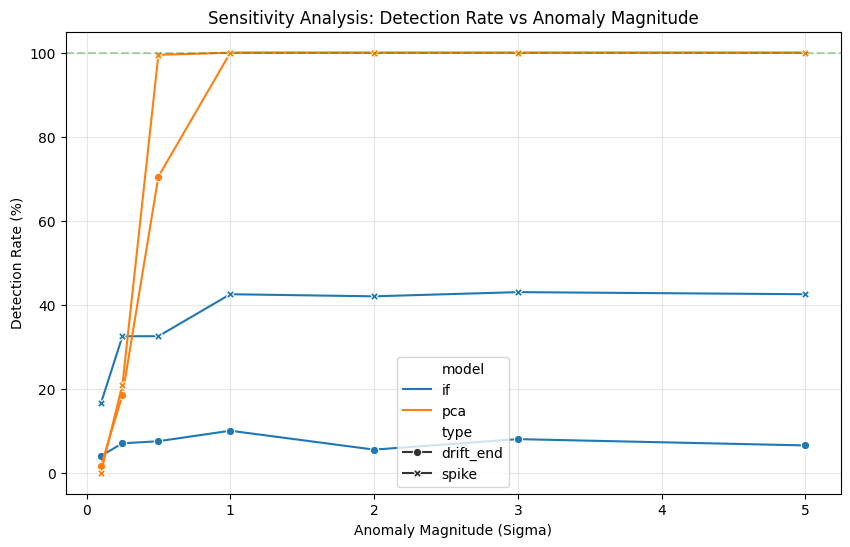

In [7]:
def run_baseline_stress_test(model, model_type, X_data, anomaly_type, magnitude=0.5, num_samples=200):
    indices = np.random.choice(len(X_data), num_samples, replace=False)
    results = []
    
    for idx in indices:
        row = X_data.iloc[idx].values.copy()
        
        # Inject Anomaly
        if anomaly_type == 'spike':
            row[0] += magnitude
        elif anomaly_type == 'drift_end':
            row[1] += magnitude
        elif anomaly_type == 'freeze':
            pass
            
        # Predict input wrapped in DataFrame
        input_data = pd.DataFrame([row], columns=X_data.columns)
        
        detected = False
        score = 0
        
        if model_type == 'pca':
            error = get_pca_reconstruction_error(model, input_data)[0]
            detected = error > THRESHOLD_PCA
            score = error
        elif model_type == 'if':
            pred = model.predict(input_data)[0]
            detected = (pred == -1)
            score = model.decision_function(input_data)[0] * -1 # Invert so higher is more anomalous for plotting
            
        results.append({
            'type': anomaly_type,
            'model': model_type,
            'magnitude': magnitude,
            'detected': detected,
            'score': score
        })
        
    return pd.DataFrame(results)

print("Running Sensitivity Analysis...")
MAGNITUDES = [0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0]
results_list = []

for mag in MAGNITUDES:
    print(f"Testing Magnitude: {mag}")
    # PCA
    results_list.append(run_baseline_stress_test(pca, 'pca', df_test, 'spike', magnitude=mag))
    results_list.append(run_baseline_stress_test(pca, 'pca', df_test, 'drift_end', magnitude=mag))
    
    # IF
    results_list.append(run_baseline_stress_test(iso_forest, 'if', df_test, 'spike', magnitude=mag))
    results_list.append(run_baseline_stress_test(iso_forest, 'if', df_test, 'drift_end', magnitude=mag))

# Freeze Tests (Single pass, magnitude 0.0)
results_list.append(run_baseline_stress_test(pca, 'pca', df_test, 'freeze', magnitude=0.0))
results_list.append(run_baseline_stress_test(iso_forest, 'if', df_test, 'freeze', magnitude=0.0))

# Combine
all_res = pd.concat(results_list)

# Save Detailed Results
all_res.to_csv(os.path.join(RESULTS_DIR, "baseline_sensitivity.csv"), index=False)
print(f"\u2705 Saved detailed results to {RESULTS_DIR}/baseline_sensitivity.csv")

# Sensitivity Summary
sens_summary = all_res.groupby(['model', 'type', 'magnitude'])['detected'].mean().reset_index()
sens_summary['detection_rate'] = sens_summary['detected'] * 100
print(sens_summary)
sens_summary.to_csv(os.path.join(RESULTS_DIR, "baseline_sensitivity_summary.csv"), index=False)

# --- Visualization: Sensitivity Curve ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=sens_summary[sens_summary['type'] != 'freeze'], x='magnitude', y='detection_rate', hue='model', style='type', markers=True, dashes=False)
plt.axhline(100, color='green', linestyle='--', alpha=0.3)
plt.title("Sensitivity Analysis: Detection Rate vs Anomaly Magnitude")
plt.ylabel("Detection Rate (%)")
plt.xlabel("Anomaly Magnitude (Sigma)")
plt.ylim(-5, 105)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(RESULTS_DIR, "sensitivity_curve.png"))
print("\u2705 Saved Sensitivity Curve")

## 5. Conclusion
**PCA** performs well on magnitude anomalies (Spike) but fails on temporal ones (Freeze) unless they break the linear correlation space significantly.
**Isolation Forest** struggles with point-wise detection in this context without feature engineering (lagged windows).

This justifies the need for **LSTM Autoencoder** (Notebook 06) which leverages temporal context.